# Wellcome to my neural network with MNIST

In this Jupiter Notebook, I will program a neural network, which can recognize the handwritten digits from the MNIST dataset. 
The baseline of my code is the tutarial on https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/. I also got some information from your tutorials on GitHub.

### Imports

In [1]:
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import keras
import seaborn as sn
import pandas as pd
import tensorflow as tf 
import datetime
import os
import importlib
import random
import sklearn
from pyexpat import model
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout 
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier


KeyboardInterrupt: 

### Import Dataset

At first, we want to import the MNIST dataset. The import code was not my own creation, I got it from the tutorial. In this tutorial, the all code is written in functions. At first, I had some problems because we need to call the function to get values, but for an improved overview functions are much better. With my main focus on data analysis, I looked at the first handwritten images. Nearly all of them have a white frame with each 2 pixels over, under, left and right of the handwritten digit. With a model size of 28x28 pixels, we get 784 values for each picture. If we resize the pictures through removing the first 2 pixels from each site, we get a picture with 24x24 pixels. Now we have 576 values, which is a reduction of over 26 percent. This should improve the runtime. 

In [143]:
# load train and test dataset
from matplotlib import axes

def load_dataset():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
    x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    x_test_original = x_test
    
    # Resize the train pictures to 24x24
    x_train_chopt = [[] for _ in range(len(x_train))]
    x_train_chopt2 = [[] for _ in range(len(x_train))]
    for i in range(len(y_train)):
        x_train_chopt[i] = x_train[i]
        x_train_chopt[i] = x_train_chopt[i][2:]
        x_train_chopt[i] = x_train_chopt[i][:-2]
        x_train_chopt2[i] = [[] for _ in range(24)]    
        for j in range(0, 24):
            x_train_chopt2[i][j] = x_train_chopt[i][j]
            x_train_chopt2[i][j] = x_train_chopt2[i][j][2:]
            x_train_chopt2[i][j] = x_train_chopt2[i][j][:-2]
    x_train = np.array(x_train_chopt2)

    # Resize the test pictures to 24x24
    x_test_chopt = [[] for _ in range(len(x_test))]
    x_test_chopt2 = [[] for _ in range(len(x_test))]
    for i in range(len(y_test)):
        x_test_chopt[i] = x_test[i]
        x_test_chopt[i] = x_test_chopt[i][2:]
        x_test_chopt[i] = x_test_chopt[i][:-2]
        x_test_chopt2[i] = [[] for _ in range(24)]    
        for j in range(0, 24):
            x_test_chopt2[i][j] = x_test_chopt[i][j]
            x_test_chopt2[i][j] = x_test_chopt2[i][j][2:]
            x_test_chopt2[i][j] = x_test_chopt2[i][j][:-2]
    x_test = np.array(x_test_chopt2)

    return x_train, y_train, x_test, y_test, x_test_original

# scale pixels
def prep_pixels(x_train, x_test):
    train_norm = x_train.astype('float32')
    test_norm = x_test.astype('float32')
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
   
    return train_norm, test_norm

def print_sampels():
    x_train, y_train, x_test, y_test, x_test_original = load_dataset()

    # plot first few images before resize
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(True)
        plt.imshow(x_test_original[i], cmap=plt.get_cmap('gray'))

    plt.show()

    # plot first few images after resize
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(True)
        plt.imshow(x_test[i], cmap=plt.get_cmap('gray'))
    plt.show()

print_sampels()

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001EACB21BD90>
Traceback (most recent call last):
  File "c:\Users\rapha\AppData\Local\Programs\Python\Python310\lib\weakref.py", line 371, in remove
    self = selfref()
KeyboardInterrupt: 


The print_sampels function outputs the first 9 samples of the test dataset. In the first picture, you can see the unchanged handwritten digits. The second image shows the zoomed images with 24x24 pixels. We could reduce the image size without the lost of any information.  

To evaluate the process, I have trained our model 2 times. The fixed parameters were 3 folds, 8 epochs with a batch size of 8.

At first, I used the normal dataset with the 28x28 pixels images. The last test evaluation got an accuracy of 98.37 % with a lost of 0.0780. The exact values can be looked up in the file 'evaluated_test_28.txt'. The time the model needs to train is difficult to compare, since this also depends on the processor performance. I'll try to compare the required times anyway. The first model needs 19 minutes for training and test.

The second time, I used the zoomed images with 24x24 pixels. The last test evaluation got an accuracy of 97.93 % with a lost of 0.0732. The exact values can be looked up in the file 'evaluated_test_24.txt'. The second model needs 16 minutes for training and test.

So in completion we improve our runtime by 15 percent, but our second accuracy is not as good as the first one. 

### Define Model

In the next function, I define my used model for this project. The define_model function was also a part of the tutorial. To improve the accuracy of the model, I added some layers. One new layer was the Dropout. If the model overfits, the evaluation of the test set gets worse. To circumvent this error, 20 % of the neurons are removed. With these improvements, we get an accuracy of 0.9876 and a lost of 0.0565. The exact values can be looked up in the file 'evaluated_test_24_imp.txt'.

In [ ]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(24, 24, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(24, 24, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(24, 24, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(24, 24, 1)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(.2, noise_shape=None, seed=None))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = define_model()
model.summary()


Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 22, 22, 32)        320       
                                                                 
 conv2d_56 (Conv2D)          (None, 20, 20, 32)        9248      
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_58 (Conv2D)          (None, 6, 6, 64)          36928     
                                                                 
 flatten_55 (Flatten)        (None, 2304)              0         
                                                     

### Evaluate Model

In the evaluate_model function we start training and testing our model. While reading about the k-Fold Cross-Validation, and it is easy and effective validation, I chose to try to implement this in to my code. Through my research, I got on the tutorial, which I used as baseline of my code. After some patches I got the code to work and with some optical embellishments and some adaptation to the fold, epochs and batch_size parameters we are good to go.

In [ ]:
def evaluate_model(dataX, dataY, n_folds=6):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	fold_count = 1 
	es_callbacks = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=4)
	
	for train_ix, test_ix in kfold.split(dataX):
		print("_"*120)
		print("Fold-{}".format(fold_count))
		print('_'*120)
		print('Start Training and Validation')
		fold_count = fold_count + 1
		# define model
		model = define_model()
		x_train, y_train, x_test, y_test = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		history = model.fit(x_train, y_train, epochs=8, batch_size=8, validation_data=(x_test, y_test), callbacks=[es_callbacks])
		# evaluate model
		print('\n')
		print('Start Testing and Evaluation')
		acc = model.evaluate(x_test, y_test)
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

### Plot the Diagrams

The summarize_diagnostics function returns us the accuracy and the lost values for each epoch and plots these values in a diagram. For an improved overview, I decided to plot all the graphs in two different diagrams. One for the lost and one for the accuracy. I also added a legend to the diagrams. 

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  for i in range(len(histories)):
  
    if(i == 1):
      lab_train = 'train'
      lab_test = 'test'
    else:
      lab_train = ''
      lab_test = ''

    plt.subplot(1, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label= lab_train)
    plt.plot(histories[i].history['val_loss'], color='red', label= lab_test)
  plt.legend(loc="upper right")
  plt.show()

  for i in range(len(histories)): 
   
    if(i == 1):
      lab_train = 'train'
      lab_test = 'test'
    else:
      lab_train = ''
      lab_test = ''

    plt.subplot(1, 1, 1)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label= lab_train)
    plt.plot(histories[i].history['val_accuracy'], color='red', label= lab_test)
  plt.legend(loc="lower right")
  plt.show()

### Run the Model

The last function is the most important function. The run_test_harness execute all the different functions. Now we really start training and testing our model.

________________________________________________________________________________________________________________________
Fold-1
________________________________________________________________________________________________________________________
Start Training and Validation
Epoch 1/8
5000/5000 [==============================] - 71s 14ms/step - loss: 0.1861 - accuracy: 0.9453 - val_loss: 0.0764 - val_accuracy: 0.9783
Epoch 2/8
5000/5000 [==============================] - 71s 14ms/step - loss: 0.0758 - accuracy: 0.9784 - val_loss: 0.0663 - val_accuracy: 0.9808
Epoch 3/8
5000/5000 [==============================] - 67s 13ms/step - loss: 0.0620 - accuracy: 0.9814 - val_loss: 0.0563 - val_accuracy: 0.9858
Epoch 4/8
5000/5000 [==============================] - 67s 13ms/step - loss: 0.0473 - accuracy: 0.9863 - val_loss: 0.0585 - val_accuracy: 0.9835
Epoch 5/8
5000/5000 [==============================] - 76s 15ms/step - loss: 0.0426 - accuracy: 0.9877 - val_loss: 0.0747 - val_accuracy: 0.9

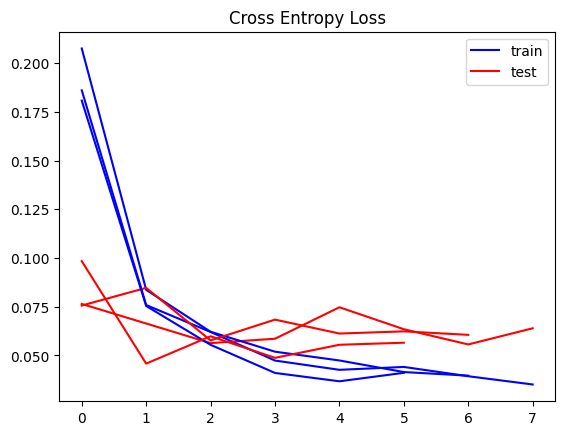

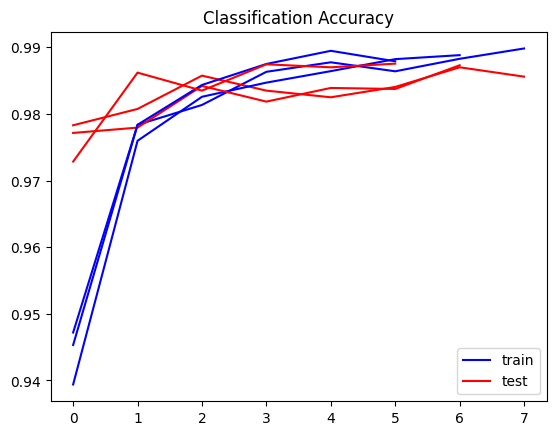

In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
    x_train, y_train, x_test, y_test, x_test_original = load_dataset()
    x_train, x_test = prep_pixels(x_train, x_test)
    scores, histories = evaluate_model(x_train, y_train)
    summarize_diagnostics(histories)
    
run_test_harness()